# Data loading and preprocessing

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


def encode_label(column):
    gby = column.groupby(by=column, sort=True, dropna=False).size()

    encoded = {}
    to_encode = list(gby.index)
    for i, name in enumerate(to_encode):
        encoded[name] = i

    return column.replace(to_replace=encoded)


def scale_data(column):
    mean = column.mean()
    std = column.std()
    
    return (column - mean)/std

    

data = pd.read_csv('../data/train.csv')
# test = pd.read_csv('../data/test.csv')  test dataset doesn't contain Y labels


y = data['SalePrice']


to_drop = ['Id', 'MasVnrArea', 'MasVnrType', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'MoSold',
           'SaleType', 'SalePrice', 'LotFrontage']

x = data.drop(columns=to_drop)

# Transform date to "time distance" from now

x['YearBuilt'] = 2022 - x['YearBuilt']
x['YearRemodAdd'] = 2022 - x['YearRemodAdd']
x['YrSold'] = 2022 - x['YrSold']

continuous_cols = ['LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
                   '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                   'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                   'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

categorical_cols = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
                    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
                    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual',
                    'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                    'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
                    'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                    'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleCondition']

# encode categorical features and scale continuous 

x[categorical_cols] = x[categorical_cols].apply(lambda col: encode_label(col))
x[continuous_cols] = x[continuous_cols].apply(lambda col: scale_data(col))

train, test, y_train, y_test = train_test_split(x, y, random_state=0)

print(train.shape)
print(test.shape)

(1095, 71)
(365, 71)


## Let's take a look at transformed dataset.

In [41]:
train.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleCondition
1292,6,4,-0.392418,1,2.0,3,3,0,0,0,...,-0.359202,-0.116299,-0.270116,-0.068668,3.0,4.0,4.0,-0.087658,13,4
1018,8,3,0.026767,1,2.0,0,3,0,2,0,...,-0.359202,-0.116299,-0.270116,-0.068668,3.0,4.0,4.0,-0.087658,15,4
1213,8,3,-0.027134,1,2.0,0,3,0,1,0,...,-0.359202,-0.116299,-0.270116,-0.068668,3.0,4.0,4.0,-0.087658,16,4
1430,5,3,1.143459,1,2.0,2,3,0,4,0,...,-0.359202,-0.116299,-0.270116,-0.068668,3.0,4.0,4.0,-0.087658,16,4
810,0,3,-0.037754,1,2.0,3,3,0,4,0,...,-0.359202,-0.116299,-0.270116,16.059839,1.0,0.0,4.0,-0.087658,16,4


## Looks like everything went as expected.
We received mix of encoded categorical features and scaled continuous features.
We could also take another approach using One Hot encoding, but for random forest models it is better to use ordinal encoding to reduce number of features.

# Models
## Random Forest

Loss:  0.132


Text(0.5, 0, 'Random Forest Feature Importance')

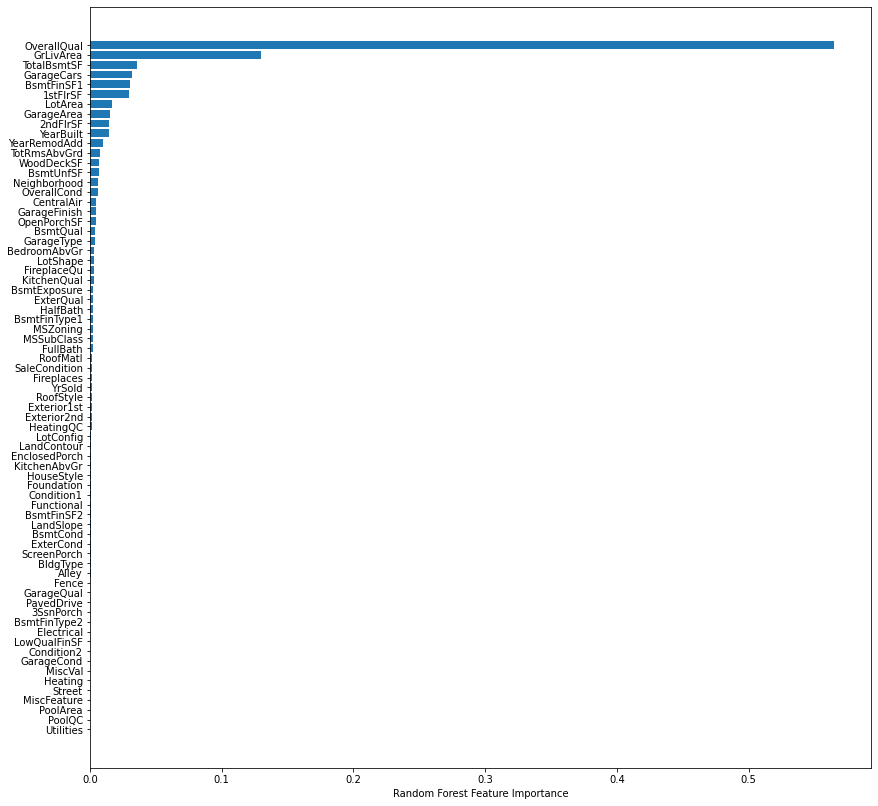

In [42]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt

def compute_rmsle(y_test: np.ndarray, y_pred: np.ndarray, precision: int = 2) -> float:
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    return round(rmsle, precision)

rf = RandomForestRegressor(n_estimators=40, random_state=0)
rf.fit(train, y_train)
y_pred = rf.predict(test)

print("Loss: ", compute_rmsle(np.array(y_test), np.array(y_pred), 3))

plt.rcParams["figure.figsize"] = (14,14)


sorted_idx = rf.feature_importances_.argsort()
plt.barh(train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")


## Random Forest with PCA
### PCA is not helping with the loss, but  it's reducing number of features. It could be helpful to train the model with large dataset (to speed calculations) which is not the case here.
### As we can see, with only 11 new features (out of more than 70) we are receving similar results.

Loss:  0.154


Text(0.5, 0, 'Random Forest Feature Importance')

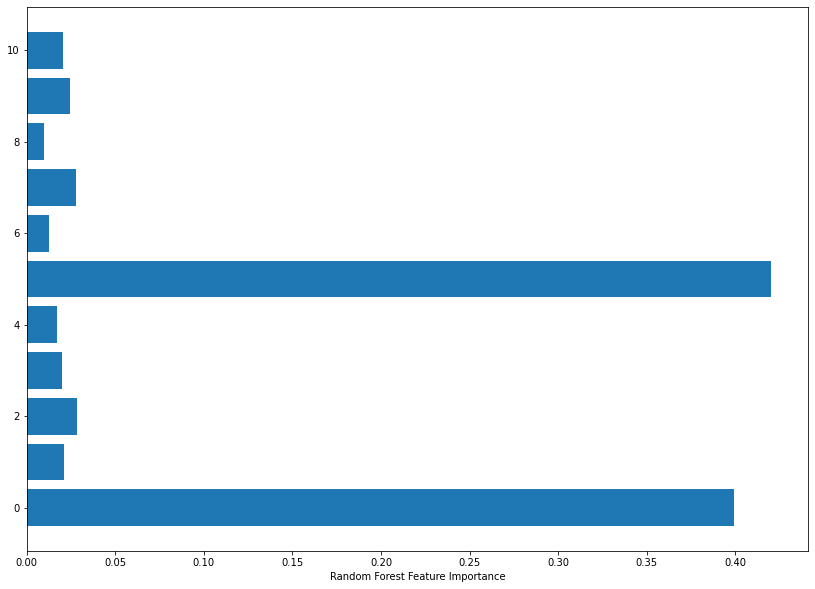

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=11)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

train, test, y_train, y_test = train_test_split(principalDf, y, random_state=0)

rf = RandomForestRegressor(n_estimators=40, random_state=2)
rf.fit(train, y_train)
y_pred = rf.predict(test)

print('Loss: ', compute_rmsle(np.array(y_test), np.array(y_pred), 3))

plt.rcParams["figure.figsize"] = (14,10)

sorted_idx = rf.feature_importances_.argsort()
plt.barh(train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")



## Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression

train, test, y_train, y_test = train_test_split(x, y, random_state=0)

lr = LinearRegression().fit(train, y_train)
predictions = lr.predict(test)
predictions = abs(predictions)

print('Loss: ', compute_rmsle(np.array(y_test), np.array(predictions), 3))

Loss:  0.202


## Now we choose only few features with biggest importance from random forest model.
### As we can see, the loss is not much higher. 

In [35]:

to_choose = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'BsmtFinSF1', '1stFlrSF', '2ndFlrSF',
            'LotArea', 'GarageArea', 'YearBuilt']

X_small = x[to_choose]

train, test, y_train, y_test = train_test_split(X_small, y, random_state=0)

lr = LinearRegression().fit(train, y_train)
predictions = lr.predict(test)
predictions = abs(predictions)
#train.head()
print('Loss: ', compute_rmsle(np.array(y_test), np.array(predictions), 3))

Loss:  0.21
